In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

In [2]:
# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = keras.datasets.cifar10.load_data()
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)

X_train shape is  (50000, 32, 32, 3)
X_test shape is  (10000, 32, 32, 3)


In [5]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [6]:
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32)
X_test_gray shape is  (10000, 32, 32)


In [7]:
X_train_gray = np.expand_dims(X_train_gray, axis=-1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32, 1)
X_test_gray shape is  (10000, 32, 32, 1)


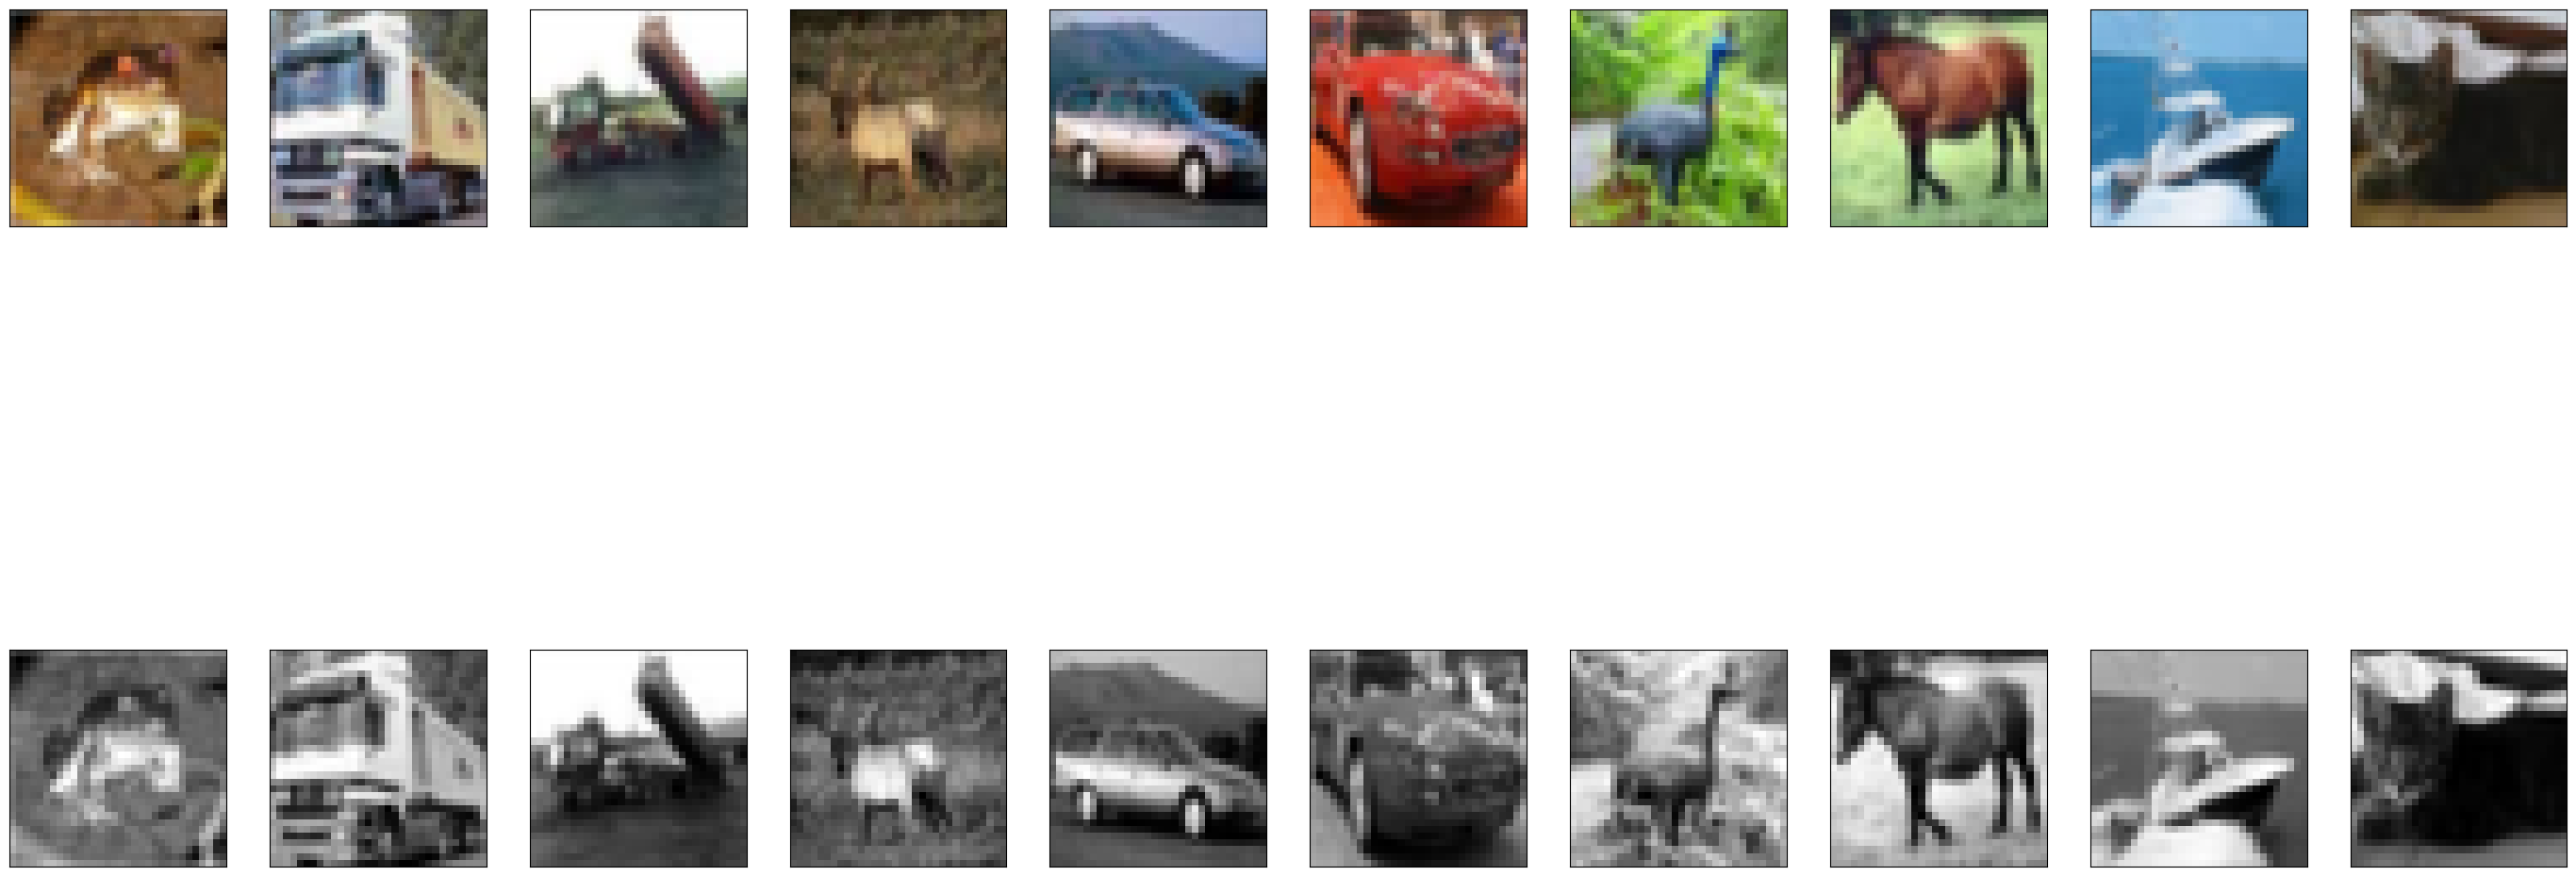

In [8]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_train_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

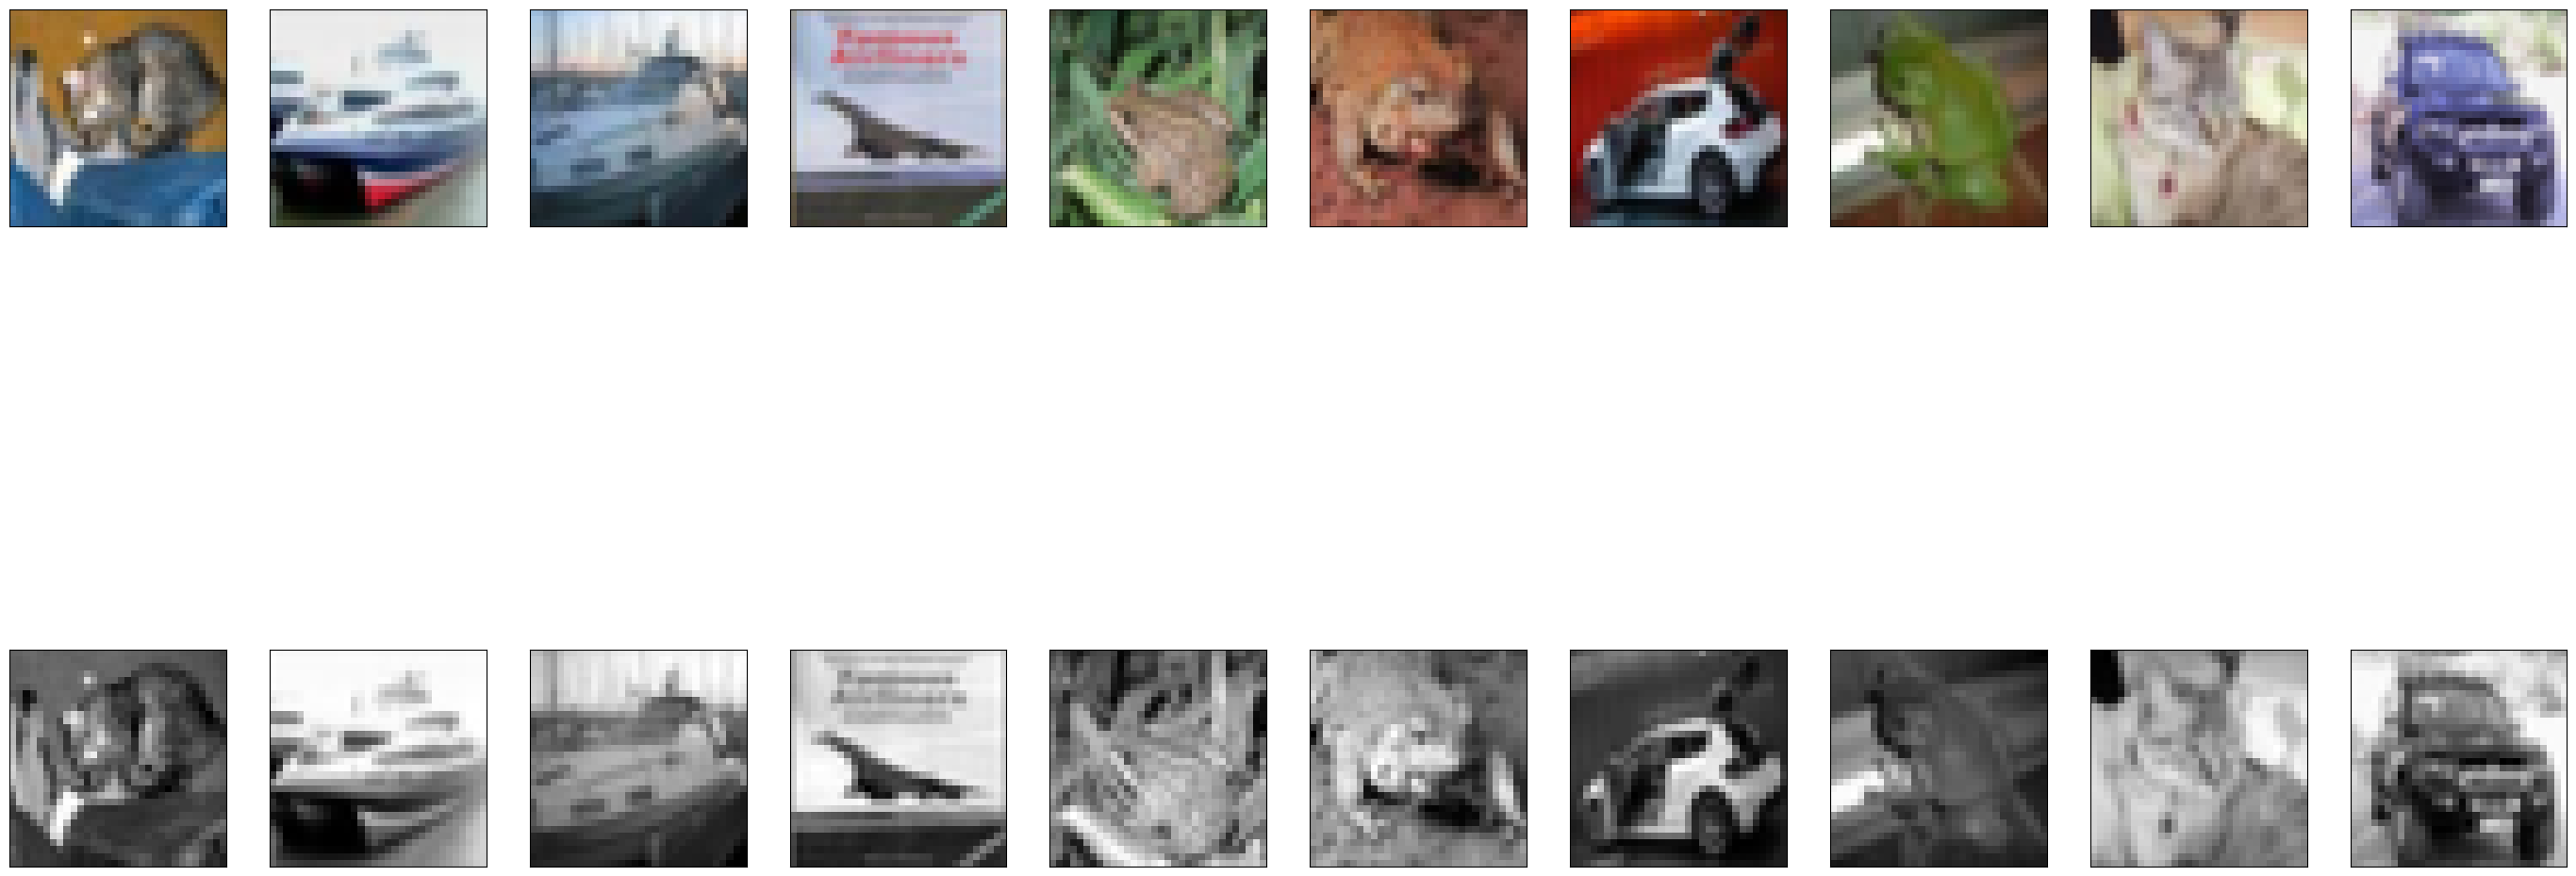

In [9]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [10]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(32,32, 1))
# Encoder
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
# Decoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
# Adjust the output layer for an RGB image (3 channels)
decoder = keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,075 (293.26 KB)

 Trainable params: 75,075 (293.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
!pip install pydot


In [25]:
!pip install graphviz


In [26]:
import pydot
from graphviz import Digraph
print("pydot and graphviz are installed and ready to use.")


pydot and graphviz are installed and ready to use.


In [27]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint("autoencoder.keras", save_best_only=True)


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint("autoencoder.keras", save_best_only=True)
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
    X_train_gray, X_train, 
    epochs=10, 
    validation_data=(X_test_gray, X_test), 
    callbacks=[checkpoint_cb]
)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.0159 - val_loss: 0.0091
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.0066 - val_loss: 0.0067


In [13]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,val_loss
0,0.011411,0.009094
1,0.008608,0.007985
2,0.007916,0.007827
3,0.007493,0.007572
4,0.007208,0.006914
5,0.007012,0.007001
6,0.006876,0.006699
7,0.006766,0.006757
8,0.006681,0.006583
9,0.006612,0.006708


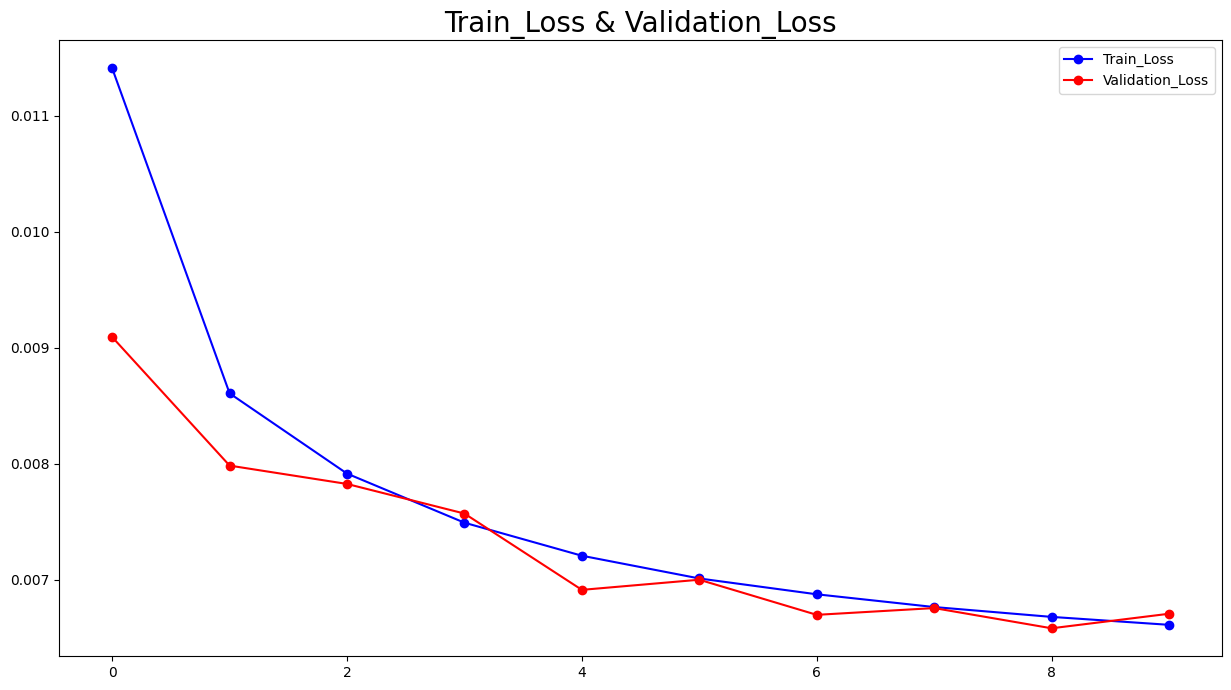

In [14]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [15]:
autoencoder.evaluate(X_test_gray,X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0068


0.006707868073135614

In [16]:
predictions = autoencoder.predict(X_test_gray)
predictions.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


(10000, 32, 32, 3)

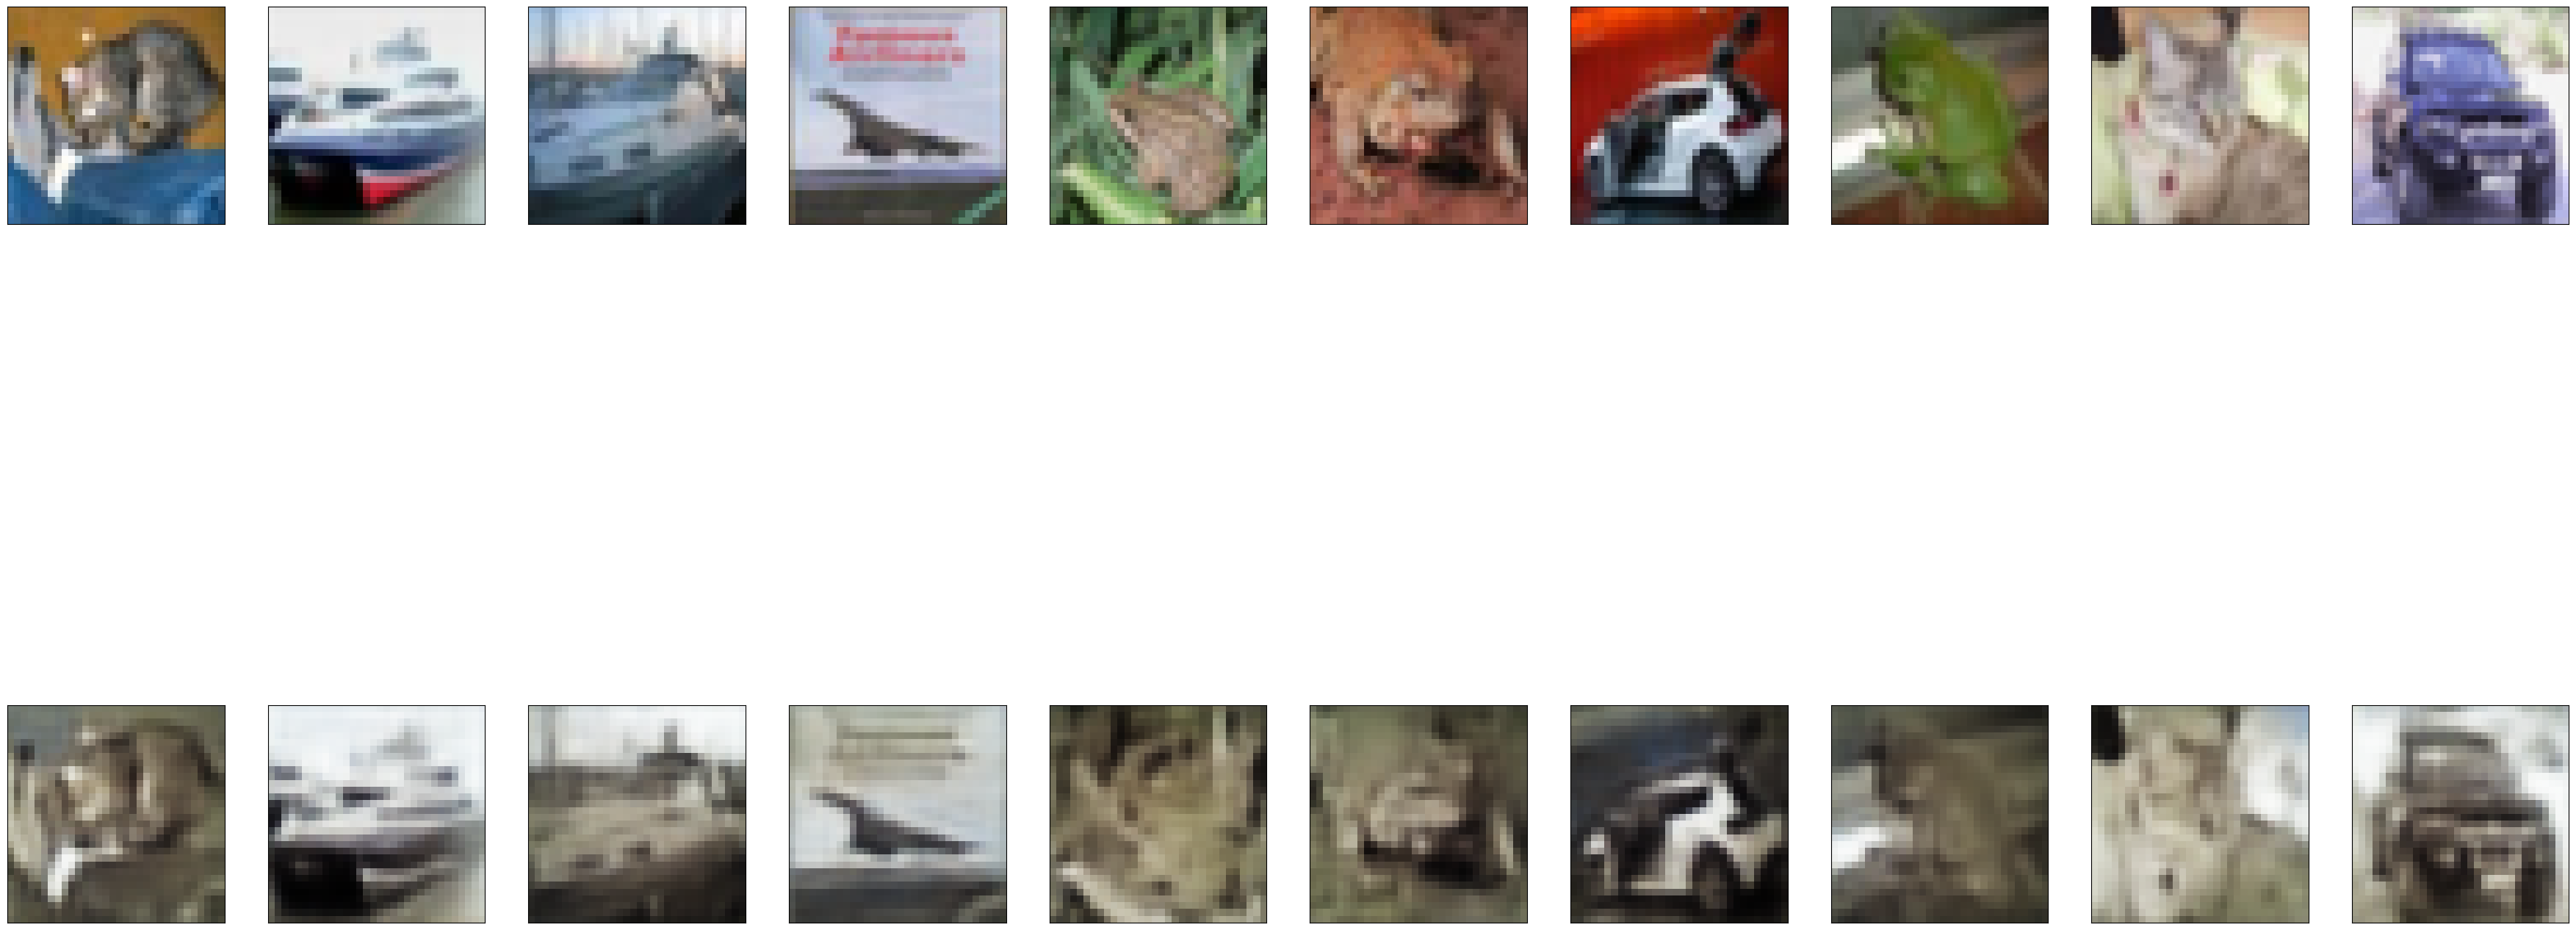

In [17]:
n=10
plt.figure(figsize=(45,35))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [18]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(X_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))


Average PSNR = 21.67795979460843
